# OmniFold Demo CLAS6

In this tutorial, we showcase the OmniFold method for universally unfolding collider data using synthetic datasets of jets.

Unfolding is the problem of estimating the particle-level (`truth`, this is basically what we want to find for our date) information from the measured detector-level data (`data`, the measurement). The detector is imperfect and smears the particle-level radiation pattern, giving rise to the need to unfold. OmniFold uses a synthetic dataset where the particle-level (`generation`) and detector-level (`simulation`) information are both known.

OmniFold is an iterative unfolding procedure consisting of two steps.
* First, the `simulation` is reweighted to the `data`.
* Second, the previous `generation` is reweighted to the new `generation`.

OmniFold results in a set of weights for the `generation` that reweight it to an estimate for the `truth` distribution.

%pip install numpy
%pip install matplotlib
%pip install keras
%pip install tensorflow
%pip install energyflow
%pip install uproot

In [1]:
# %pip install numpy 
# %pip install matplotlib 
# %pip install keras 
# %pip install tensorflow 
# %pip install energyflow
# %pip install PyPDF2
# %pip install uproot

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import energyflow as ef
import energyflow.archs

sys.path.append("../")
import omnifold
import modplot
# import ibu
# import uproot


2024-07-10 10:19:38.749356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Plot Style

In [3]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

In [4]:
names = ['pdg','pid_gen','pid_rec','cz_rec','cz_numu_rec','e_rec','e_numu_rec','cz_gen','e_gen','type','weight']

In [5]:
input_data = pd.read_csv("/Users/wingyanma/Documents/GitHub/pisa/pisa_examples/resources/events/J23_all_events.csv",
                         names=names, header=0, index_col=[0])


In [6]:
input_data

,pdg,pid_gen,pid_rec,cz_rec,cz_numu_rec,e_rec,e_numu_rec,cz_gen,e_gen,type,weight
0,14,numu,numu,0.494961,0.590685,0.853201,1.157009,0.855655,3.841143,1,1
1,14,numu,numu,0.274824,0.141403,4.300221,4.784906,0.113431,4.579452,1,1
2,14,numu,numu,0.242091,0.154218,2.578972,2.529813,0.404237,2.226287,1,1
3,14,numu,numu,-0.406088,-0.440340,2.419158,2.477218,-0.807746,2.606570,1,1
4,14,numu,numubar,0.597770,0.653224,3.485928,3.430741,0.187372,3.119193,1,1
...,...,...,...,...,...,...,...,...,...,...,...
94970,14,nc,nc,0.357342,0.369064,1.798511,2.144140,0.681854,4.422088,0,1
94971,-12,nc,nc,-0.290957,-0.492486,2.885988,3.517319,0.044246,5.999827,0,1
94972,12,nc,nc,-0.570296,-0.735233,1.708040,1.500363,-0.395516,2.657809,0,1
94973,14,nc,nc,-0.072436,-0.063474,4.060598,4.322109,-0.026144,7.631851,0,1


In [7]:
new_label = {"pid_gen": {"numu": 0, "numubar": 1, "nue": 2, "nuebar": 3, "nc": 4}}
input_data.replace(new_label , inplace = True)
new_label = {"pid_rec": {"numu": 0, "numubar": 1, "nue": 2, "nuebar": 3, "nc": 4}}
input_data.replace(new_label , inplace = True)
theta_rec = np.arccos(input_data['cz_rec'])/np.pi*180.
theta_gen = np.arccos(input_data['cz_gen'])/np.pi*180.

input_data['theta_rec'] = theta_rec
input_data['theta_gen'] = theta_gen

In [8]:
min(input_data['theta_gen']), max(input_data['theta_gen'])

(0.4546659936491172, 179.73634887223196)

In [9]:
sim = input_data.sample(frac=0.7, random_state=1)
idx = sim.index
data = input_data[~input_data.index.isin(idx)]

datasets = {'simul':sim,'data':data}

In [10]:
# A dictionary of the dictionaries 
datasets = {'simul':sim,'data':data}

In [11]:
data

,pdg,pid_gen,pid_rec,cz_rec,cz_numu_rec,e_rec,e_numu_rec,cz_gen,e_gen,type,weight,theta_rec,theta_gen
0,14,0,0,0.494961,0.590685,0.853201,1.157009,0.855655,3.841143,1,1,60.332831,31.167860
5,14,0,0,-0.141743,-0.247919,1.386829,1.466295,-0.289032,1.385311,1,1,98.148747,106.800032
7,14,0,0,0.563811,0.571079,2.315544,2.056042,0.465275,2.145338,1,1,55.680249,62.271961
9,14,0,0,0.676379,0.882732,0.716852,0.828296,0.954780,1.034004,1,1,47.438700,17.296348
15,14,0,0,0.880363,0.888954,0.852772,0.897762,0.684703,0.960108,1,1,28.313868,46.787779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94959,12,4,4,-0.321601,-0.338514,2.788977,3.256436,-0.214398,9.492567,0,1,108.759751,102.380208
94961,-14,4,4,-0.162246,0.022859,2.258630,2.477290,-0.299260,5.933968,0,1,99.337262,107.413176
94967,-14,4,4,0.054821,-0.543451,0.636991,0.705622,-0.269792,10.802971,0,1,86.857431,105.651885
94970,14,4,4,0.357342,0.369064,1.798511,2.144140,0.681854,4.422088,0,1,69.062954,47.011304


In [12]:
# if you want to check the format run this
print(datasets) 

{'simul':        pdg  pid_gen  pid_rec    cz_rec  cz_numu_rec     e_rec  e_numu_rec  \
91051  -14        4        4 -0.171066    -0.058375  4.216917    4.948274   
6863    14        0        0 -0.101305    -0.265679  0.705177    0.671842   
61143   12        2        0  0.521957     0.288055  0.854483    0.832248   
74532   12        2        2 -0.312521    -0.190026  1.165914    1.154446   
90653   14        4        4 -0.516587    -0.547464  3.307557    3.897402   
...    ...      ...      ...       ...          ...       ...         ...   
91973  -14        4        4 -0.537341    -0.785293  1.350644    1.577565   
15708   14        0        0  0.742337     0.804397  2.541289    2.220261   
42905  -14        1        1 -0.219705    -0.408613  4.329014    4.243622   
69883   12        2        2  0.593715     0.586638  2.914048    3.176288   
7627    14        0        4 -0.660777    -0.715028  1.438600    1.629151   

         cz_gen      e_gen  type  weight   theta_rec   theta_gen 

## Specifying the Unfolding Problem

OmniFold requires particle-level event generators as well as a faithful simulation of the detector, both are in HS. 

In [13]:
# choose what is MC(MonteCarlo/simulations) and Data in this context
synthetic, nature = datasets['simul'], datasets['data']

We also have to specify `itnum`: how many iterations of the unfolding procedure we want to do.

**Customize**: Change `itnum` to your desired number of unfolding iterations.

In [14]:
# how many iterations of the unfolding process
itnum = 3

There are three flavors of OmniFold. In order of increasing sophistication, they are:
* **UniFold**: Represent the jet as a single observable.
* **MultiFold**: Represent the jet as multiple observables.
* **OmniFold**: Represent the jet as a set of particles.

i am not shure if this is omnifold or multifold or what is the difference

In [15]:
# Phase space of the correction
# obs_multifold = ['pid', 'theta', 'e'] 
obs_multifold = ['theta', 'e'] 

The observables are already computed in the samples. We will read them in as an observable dictionary `obs` and also specify histogram style information.

**Customize**: Add entries to `obs` to define your own observables to be used in MultiFold or to see the unfolding performance on them.

In [16]:
# a dictionary to hold information about the observables
obs = {}

# obs.setdefault('pid', {}).update({
#     'func': lambda dset, ptype: dset['pid_' + ptype],
#     'nbins_det': 5, 'nbins_mc': 5,
#     'xlim': (-0.5, 4.5), 'ylim': (0, 1.5),
#     'xlabel': r'PID', 'symbol': r'PID',
#     'ylabel': r'Normalized Cross Section ',
#     'stamp_xy': (0.425, 0.65),
# })

obs.setdefault('theta', {}).update({
    'func': lambda dset, ptype: dset['theta_'+ ptype],
    'nbins_det': 18, 'nbins_mc': 18,
    'xlim': (0., 180.), 'ylim': (0, 0.02),
#     'xlabel': r'$\nu$[$GeV$]', 'symbol': r'$\nu$',
    'xlabel': r'$\theta$', 'symbol': r'$\theta$',
#     'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

obs.setdefault('e', {}).update({ 
    'func': lambda dset, ptype: dset['e_' + ptype],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0., 20.), 'ylim': (0, 0.5),
#     'xlabel': r'$Pt^2$[GeV]', 'symbol': r'$Pt^2$',
    'xlabel': r'$Ee$[GeV]', 'symbol': r'$Ee$',
#     'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper right', 'legend_ncol': 1,
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '-', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': 'dashed', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

Now all that remains is to get the values of the specified observables and compute the histograms with the specified binnings. As an unfolding benchmark, we also obtain the unfolding results of Iterative Bayesian Unfolding (IBU) as implemented in `ibu.py`. The following cell takes care of all of these aspects.

In [17]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # Add the array with the data to the las dictionary
    # calculate observable for GEN, (REC)SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'rec')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'rec')

    # setup bins
    # ob['rec/det or gen/mc'] = np.linspace(min val, max val, nbins + 1)
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    # = np.linspace(bin-array except the last number, bin-array except the first number) all array vals divided by 2
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    # Second val - first val = width
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    #  np.histogram(data Array , binning array, density=True(this normalize the histogram))
    # the [0] is to select the first return object of the method,which is the number of event per bin
    # in this case normalized beacause density=True
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    # modplot.calc_hist(Data array, binning array,  this just select if the bigger or equal of the binning selection 
    # goes in the right or in the left)
    # [:2] this returns the first 2 object created by the method that  is a histgram and the errors 
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'],
                                                               bins=ob['bins_mc'], density=True)[:2]

    

    # compute (and normalize) the response matrix between GEN and SIM
#     ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
#     ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
#     # perform iterative Bayesian unfolding
#     ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
#                          ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
#     ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with theta
Done with e


## OmniFold

Now it's time to set up for the OmniFold procedure and do the unfolding!  

Here, we choose model sizes and training parameters that default to a quick training (~5 min). Even with this simplified model and training, we will closely reproduce the full results of the paper.

**Customize**: Change the model layer sizes or training parameters.

In [18]:
# How many layers and neurons for each layer to use in the deep learning
model_layer_sizes = [100, 100]
# model_layer_sizes = [100, 100, 100] # use this for the full network size

# set up the array of data/simulation detector-level observables
# X are the features/variables
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T
# Y are labels(variable that you want to know)/ weights
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['e']['dataobs'])), 
                                                np.zeros(len(obs['e']['simobs'])))))

# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['e']['genobs'])), 
                                                np.zeros(len(obs['e']['genobs'])))))

# standardize the inputs (variables- mean)/standar deviation
X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': 'Step1_{}', 'save_weights_only': False, 
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# model parameters for the Step 2 network
mc_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': 'Step2_{}', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# general training parameters
# Batch_size is the number of examples used to train the data at same time(it used all but not all at same time)
# epoch i the number of steam
# i am not sure about the last two thing hahha
fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
#fitargs = {'batch_size': 500, 'epochs': 100, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [19]:
print(X_det)

[[-0.74461613 -0.66298577]
 [ 0.30847688 -0.40176944]
 [-0.87418066  0.05284653]
 ...
 [ 0.4349891   1.03846154]
 [-0.93269871  0.34582032]
 [ 1.23331726 -0.37642664]]


The `omnifold` method within `omnifold.py` takes all the relevant information and performs the unfolding process for the specified number of iterations.

In [20]:
# apply the OmniFold procedure to get weights for the generation
multifold_ws = omnifold.omnifold(X_gen, Y_gen, X_det, Y_det, wdata, winit,
                                (ef.archs.DNN, det_args), (ef.archs.DNN, mc_args),
                                fitargs, val=0.2, it=itnum, trw_ind=-2, weights_filename='Test')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activation_2 (Activation)   (None, 2)                 0     

2024-07-10 10:20:08.943275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activation_5 (Activation)   (None, 2)                 0   

INFO:tensorflow:Assets written to: Step1_0_Epoch-1/assets


INFO:tensorflow:Assets written to: Step1_0_Epoch-1/assets


152/152 [==============================] - 5s 32ms/step - loss: 0.4211 - acc: 0.4867 - val_loss: 0.4168 - val_acc: 0.4493
Epoch 2/2
123/152 [=======================>......] - ETA: 0s - loss: 0.4189 - acc: 0.5060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss did not improve from 0.41685
4/4 [==============================] - 0s 2ms/step
Epoch 1/2
192/213 [==========================>...] - ETA: 0s - loss: 0.2749 - acc: 0.5007WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 0.27307, saving model to Step2_0_Epoch-1


INFO:tensorflow:Assets written to: Step2_0_Epoch-1/assets


INFO:tensorflow:Assets written to: Step2_0_Epoch-1/assets


213/213 [==============================] - 7s 28ms/step - loss: 0.2748 - acc: 0.4995 - val_loss: 0.2731 - val_acc: 0.5000
Epoch 2/2
201/213 [===========================>..] - ETA: 0s - loss: 0.2737 - acc: 0.5001WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 0.27307 to 0.27299, saving model to Step2_0_Epoch-2


INFO:tensorflow:Assets written to: Step2_0_Epoch-2/assets


INFO:tensorflow:Assets written to: Step2_0_Epoch-2/assets


6/6 [==============================] - 0s 3ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_6 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_7 (Activation)   (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activat


Epoch 1: val_loss improved from inf to 0.37842, saving model to Step1_1_Epoch-1


INFO:tensorflow:Assets written to: Step1_1_Epoch-1/assets


INFO:tensorflow:Assets written to: Step1_1_Epoch-1/assets


152/152 [==============================] - 6s 34ms/step - loss: 0.3773 - acc: 0.3382 - val_loss: 0.3784 - val_acc: 0.2960
Epoch 2/2
130/152 [========================>.....] - ETA: 0s - loss: 0.3768 - acc: 0.3240WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 0.37842 to 0.37833, saving model to Step1_1_Epoch-2


INFO:tensorflow:Assets written to: Step1_1_Epoch-2/assets


INFO:tensorflow:Assets written to: Step1_1_Epoch-2/assets


4/4 [==============================] - 0s 3ms/step
Epoch 1/2
197/213 [==========================>...] - ETA: 0s - loss: 0.2864 - acc: 0.5003WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 0.28511, saving model to Step2_1_Epoch-1


INFO:tensorflow:Assets written to: Step2_1_Epoch-1/assets


INFO:tensorflow:Assets written to: Step2_1_Epoch-1/assets


213/213 [==============================] - 6s 27ms/step - loss: 0.2863 - acc: 0.4998 - val_loss: 0.2851 - val_acc: 0.5000
Epoch 2/2
200/213 [===========================>..] - ETA: 0s - loss: 0.2862 - acc: 0.4998WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss did not improve from 0.28511
6/6 [==============================] - 0s 2ms/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_12 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_13 (Activation)  (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                          


Epoch 1: val_loss improved from inf to 0.44503, saving model to Step1_2_Epoch-1


INFO:tensorflow:Assets written to: Step1_2_Epoch-1/assets


INFO:tensorflow:Assets written to: Step1_2_Epoch-1/assets


152/152 [==============================] - 5s 30ms/step - loss: 0.4506 - acc: 0.5878 - val_loss: 0.4450 - val_acc: 0.6086
Epoch 2/2
125/152 [=======================>......] - ETA: 0s - loss: 0.4489 - acc: 0.6075WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 0.44503 to 0.44477, saving model to Step1_2_Epoch-2


INFO:tensorflow:Assets written to: Step1_2_Epoch-2/assets


INFO:tensorflow:Assets written to: Step1_2_Epoch-2/assets


4/4 [==============================] - 0s 2ms/step
Epoch 1/2
213/213 [==============================] - ETA: 0s - loss: 0.3098 - acc: 0.4991WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 0.30801, saving model to Step2_2_Epoch-1


INFO:tensorflow:Assets written to: Step2_2_Epoch-1/assets


INFO:tensorflow:Assets written to: Step2_2_Epoch-1/assets


213/213 [==============================] - 6s 28ms/step - loss: 0.3098 - acc: 0.4991 - val_loss: 0.3080 - val_acc: 0.5000
Epoch 2/2
207/213 [============================>.] - ETA: 0s - loss: 0.3086 - acc: 0.4999WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 0.30801 to 0.30755, saving model to Step2_2_Epoch-2


INFO:tensorflow:Assets written to: Step2_2_Epoch-2/assets


INFO:tensorflow:Assets written to: Step2_2_Epoch-2/assets


6/6 [==============================] - 0s 3ms/step


## Plot Unfolding Results

Now it's time to plot the unfolding results for all of the specified observables!

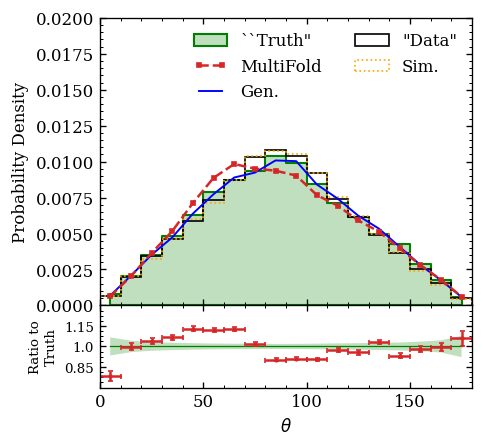

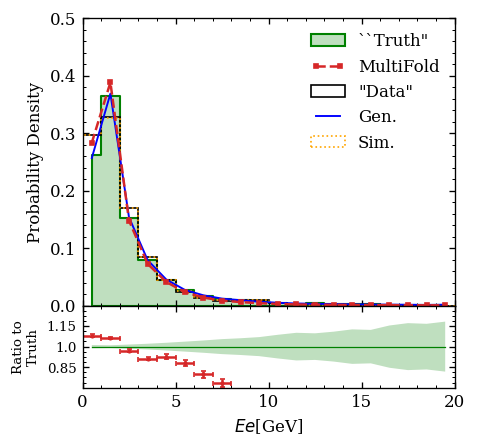

In [21]:
plot_directory  = "./plots_ori/"

for i,(obkey,ob) in enumerate(obs.items()):


    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='\"Data\"', **hist_style)


    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style, linestyle = 'dotted')

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], 
                                                   weights=multifold_ws[2*itnum], 
                                                   bins=ob['bins_mc'], density=True)[:2]
    
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # plot the IBU distribution
    #ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    # ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    #ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    #ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              #color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 0, 1] if ncol==2 else [3, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)


    # save plot.
    fig.savefig(plot_directory + 'MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')  

In [22]:
weight_dic = {'weight': multifold_ws[2*itnum]}
sim.update(weight_dic)
# print(data['weight'][data['weight']>1.05])
print(data['weight'].sum())
# output = pd.DataFrame()
# df_dictionary = pd.DataFrame([weight_dic])
# output = data.assign(weight=multifold_ws[2*itnum])

28493


In [23]:
sim

,pdg,pid_gen,pid_rec,cz_rec,cz_numu_rec,e_rec,e_numu_rec,cz_gen,e_gen,type,weight,theta_rec,theta_gen
91051,-14,4,4,-0.171066,-0.058375,4.216917,4.948274,0.016796,15.228111,0,1.000000,99.849797,89.037617
6863,14,0,0,-0.101305,-0.265679,0.705177,0.671842,0.005929,0.698152,1,0.415095,95.814305,89.660284
61143,12,2,0,0.521957,0.288055,0.854483,0.832248,-0.263994,1.230775,1,0.395617,58.536357,105.307189
74532,12,2,2,-0.312521,-0.190026,1.165914,1.154446,-0.870405,0.944739,1,1.000000,108.211199,150.505726
90653,14,4,4,-0.516587,-0.547464,3.307557,3.897402,-0.800190,6.719989,0,1.000000,121.103620,143.148260
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91973,-14,4,4,-0.537341,-0.785293,1.350644,1.577565,-0.824938,14.734999,0,1.000000,122.502809,145.582164
15708,14,0,0,0.742337,0.804397,2.541289,2.220261,0.720567,2.112979,1,0.609552,42.069099,43.898648
42905,-14,1,1,-0.219705,-0.408613,4.329014,4.243622,-0.073726,3.929028,1,0.599403,102.691723,94.228045
69883,12,2,2,0.593715,0.586638,2.914048,3.176288,0.423870,2.837134,1,1.000000,53.578902,64.920834


In [47]:
print(data['weight'][data['weight']<1])


5        0.394059
7        0.352438
9        0.358063
15       0.399031
16       0.383921
           ...   
66455    0.380264
66456    0.411709
66464    0.340540
66471    0.400940
66476    0.350494
Name: weight, Length: 19857, dtype: float64


In [ ]:
# with uproot.recreate("/home/matias/proyecto/Omnifold/Data/data_weights_" + target + ".root") as output_file:
#     output_file['ntuple_pion'] = data
#     output_file['ntuple_pion'].show()
#     output_file